In [1]:
import torch
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
# os.environ["CUDA_VISIBLE_DEVICES"]= "0, 1, 2"  # Set the GPU 2 to use
os.environ["CUDA_VISIBLE_DEVICES"]= "3" # Set the GPU 2 to use
torch.cuda.set_per_process_memory_fraction(0.9, device=None)

torch.set_num_threads(16)

In [2]:
import tensorflow as tf

# TensorFlow에서 사용 가능한 GPU를 확인합니다.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 할당을 동적으로 조절합니다.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) are available and ready to use.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU instead.")


1 GPU(s) are available and ready to use.


In [3]:
import pandas as pd
import json
import numpy as np

# CSV 파일 읽기
df_loaded = pd.read_csv('ecg_data (1).csv')

# JSON 문자열을 dictionary로 변환하고, 리스트를 다시 numpy 배열로 복원
def list_to_numpy(d):
    return {k: np.array(v, dtype=np.float32) for k, v in d.items()}

df_loaded['WaveForm'] = df_loaded['WaveForm'].apply(json.loads)
df_loaded['WaveForm'] = df_loaded['WaveForm'].apply(list_to_numpy)

# 확인


In [6]:
df = df_loaded

In [7]:
cmp = df[df['CMP'] == 1]
non_cmp = df[df['CMP'] == 0]

cmp = cmp[['PatientID','AcquisitionDate','CMP_date','WaveForm','ProcessedWaveForm']]

In [8]:
# 각 검사별로 cmp 발병 후 몇 개월 지난 시점의 검사인지 정의
import pandas as pd
def convert_to_datetime(val):
    try:
        return pd.to_datetime(val, errors='raise')
    except (ValueError, TypeError):
        return val


cmp['AcquisitionDate'] = pd.to_datetime(cmp['AcquisitionDate'], errors='coerce')
cmp['CMP_date'] = pd.to_datetime(cmp['CMP_date'], errors='coerce')

cmp['AcquisitionDate'] = cmp['AcquisitionDate'].apply(convert_to_datetime)
cmp['CMP_date'] = cmp['CMP_date'].apply(convert_to_datetime)

duration = []
for i in range(len(cmp)):
    duration.append((cmp['AcquisitionDate'].iloc[i] - cmp['CMP_date'].iloc[i]).days/30)

cmp['Duration'] = duration

In [ ]:
cmp = cmp[((cmp['Duration'] < 120)& (cmp['Duration'] >0))|(cmp['Duration']< -6)]
cmp

In [10]:
label=[]
for i in range(len(cmp)):
    if (cmp['Duration'].iloc[i] < 120)& (cmp['Duration'].iloc[i] >0):
        label.append(1)
    elif (cmp['Duration'].iloc[i]< -6):
        label.append(0)

In [11]:
cmp['Label'] = label

In [12]:
cmp['Label'].value_counts()

1    2390
0     637
Name: Label, dtype: int64

In [13]:
non_cmp['Label'] = [0]*len(non_cmp)

/tmp/ipykernel_36715/2470785605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_cmp['Label'] = [0]*len(non_cmp)


In [ ]:
non_cmp

In [15]:
tot_df = pd.concat((cmp,non_cmp))

In [16]:
tot_df.Label.value_counts()

1    2390
0    1271
Name: Label, dtype: int64

In [17]:
df = tot_df

In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
total_data = df
# PatientID별로 데이터 나누기
unique_patient_ids = total_data['PatientID'].unique()
train_ids, test_ids = train_test_split(unique_patient_ids, test_size=0.1, random_state=42)

train_df = total_data[total_data['PatientID'].isin(train_ids)]
test_df = total_data[total_data['PatientID'].isin(test_ids)]

def preprocess_data(df):
    data_list = []
    for i in range(len(df)):
        d = df['WaveForm'].iloc[i]
        if len(d) > 12:
            keys_to_exclude = {'V3R', 'V4R', 'V7'}
            filtered_dict = {key: value for key, value in d.items() if key not in keys_to_exclude}
        else:
            filtered_dict = d

        single_data = np.vstack(filtered_dict.values())
        if single_data.shape != (12, 5000):
            array_2500 = single_data
            x_2500 = np.linspace(0, 12, single_data.shape[1])
            x_5000 = np.linspace(0, 12, 5000)
            linear_interpolator = interp1d(x_2500, array_2500, kind='linear')
            array_5000 = linear_interpolator(x_5000)
            data_list.append(array_5000.T)  # (12, 5000) -> (5000, 12)
        else:
            data_list.append(single_data.T)  # (12, 5000) -> (5000, 12)
    return np.array(data_list)

# 데이터 전처리 수행
X_train = preprocess_data(train_df)
y_train = np.array(train_df['Label'])
X_test = preprocess_data(test_df)
y_test = np.array(test_df['Label'])

# 데이터 정규화 (각 채널별로)
scaler = StandardScaler()

X_train = X_train.reshape(-1, X_train.shape[-1])
X_train = scaler.fit_transform(X_train)
X_train = X_train.reshape(-1, 5000, 12)  # (12, 5000) -> (5000, 12)

X_test = X_test.reshape(-1, X_test.shape[-1])
X_test = scaler.transform(X_test)
X_test = X_test.reshape(-1, 5000, 12)  # (12, 5000) -> (5000, 12)

# 데이터셋 생성 함수
def create_tf_dataset(X, y, shuffle, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# 배치 사이즈 정의
batch_size = 32

# 텐서플로우 데이터셋 생성
train_ds = create_tf_dataset(X_train, y_train, shuffle=True, batch_size=batch_size)
val_ds = create_tf_dataset(X_test, y_test, shuffle=False, batch_size=batch_size)


/tmp/ipykernel_36715/3078307709.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  single_data = np.vstack(filtered_dict.values())
2024-08-20 04:45:21.143309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 04:45:29.567809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43584 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4c:00.0, compute capability: 8.6


In [19]:
class ViTEmbeddings(tf.keras.layers.Layer):
    def __init__(self, patch_size, hidden_size, dropout=0.0, **kwargs):
        super().__init__(**kwargs)

        self.patch_size = patch_size
        self.hidden_size = hidden_size

        # kernel_size와 strides를 작게 설정하여 더 많은 패치를 생성합니다.
        self.patch_embeddings = tf.keras.layers.Conv1D(filters=hidden_size, kernel_size=patch_size, strides=patch_size)
        self.dropout = tf.keras.layers.Dropout(rate=dropout)

    def build(self, input_shape):
        self.cls_token = self.add_weight(shape=(1, 1, self.hidden_size), trainable=True, name="cls_token")

        num_patches = input_shape[1] // self.patch_size
        self.position_embeddings = self.add_weight(
            shape=(1, num_patches + 1, self.hidden_size), trainable=True, name="position_embeddings"
        )

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        inputs_shape = tf.shape(inputs)  # N,H,W,C
        embeddings = self.patch_embeddings(inputs, training=training)

        # add the [CLS] token to the embedded patch tokens
        cls_tokens = tf.repeat(self.cls_token, repeats=inputs_shape[0], axis=0)
        embeddings = tf.concat((cls_tokens, embeddings), axis=1)

        # add positional encoding to each token
        embeddings = embeddings + self.position_embeddings
        embeddings = self.dropout(embeddings, training=training)

        return embeddings



In [20]:
class MLP(tf.keras.layers.Layer):
    def __init__(self, mlp_dim, out_dim=None, activation="gelu", dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.mlp_dim = mlp_dim
        self.out_dim = out_dim
        self.activation = activation
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.dense1 = tf.keras.layers.Dense(self.mlp_dim)
        self.activation1 = tf.keras.layers.Activation(self.activation)
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.dense2 = tf.keras.layers.Dense(input_shape[-1] if self.out_dim is None else self.out_dim)

    def call(self, inputs: tf.Tensor, training: bool = False):
        x = self.dense1(inputs)
        x = self.activation1(x)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        x = self.dropout(x, training=training)
        return x

In [24]:
class Block(tf.keras.layers.Layer):
    def __init__(
        self,
        num_heads,
        attention_dim,
        attention_bias,
        mlp_dim,
        attention_dropout=0.0,
        sd_survival_probability=1.0,
        activation="gelu",
        dropout=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.norm_before = tf.keras.layers.LayerNormalization()
        self.attn = tf.keras.layers.MultiHeadAttention(
            num_heads,
            attention_dim // num_heads,
            use_bias=attention_bias,
            dropout=attention_dropout,
        )
        self.stochastic_depth = tfa.layers.StochasticDepth(sd_survival_probability)
        self.norm_after = tf.keras.layers.LayerNormalization()
        self.mlp = MLP(mlp_dim=mlp_dim, activation=activation, dropout=dropout)

    def build(self, input_shape):
        super().build(input_shape)
        # TODO YONIGO: tf doc says to do this  ¯\_(ツ)_/¯
        self.attn._build_from_signature(input_shape, input_shape)

    def call(self, inputs, training=False):
        x = self.norm_before(inputs, training=training)
        x = self.attn(x, x, training=training)
        x = self.stochastic_depth([inputs, x], training=training)
        x2 = self.norm_after(x, training=training)
        x2 = self.mlp(x2, training=training)
        return self.stochastic_depth([x, x2], training=training)

    def get_attention_scores(self, inputs):
        x = self.norm_before(inputs, training=False)
        _, weights = self.attn(x, x, training=False, return_attention_scores=True)
        return weights

In [36]:
import tensorflow as tf

import tensorflow as tf

class StochasticDepth(tf.keras.layers.Layer):
    def __init__(self, survival_probability=1.0, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.survival_probability = survival_probability

    def call(self, inputs, training=False):
        shortcut, residual = inputs

        # Training 시에만 Stochastic Depth 적용
        if training and self.survival_probability < 1.0:
            batch_size = tf.shape(shortcut)[0]
            random_tensor = tf.random.uniform([batch_size, 1, 1], dtype=shortcut.dtype)
            binary_tensor = tf.cast(random_tensor < self.survival_probability, dtype=shortcut.dtype)

            output = tf.add(tf.multiply(residual, binary_tensor), tf.multiply(shortcut, 1.0 - binary_tensor))
            output = output / self.survival_probability
            return output
        else:
            return residual

        return output

class Block(tf.keras.layers.Layer):
    def __init__(
        self,
        num_heads,
        attention_dim,
        attention_bias,
        mlp_dim,
        attention_dropout=0.0,
        sd_survival_probability=1.0,
        activation="gelu",
        dropout=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.norm_before = tf.keras.layers.LayerNormalization()
        self.attn = tf.keras.layers.MultiHeadAttention(
            num_heads,
            attention_dim // num_heads,
            use_bias=attention_bias,
            dropout=attention_dropout,
        )
        self.stochastic_depth = StochasticDepth(sd_survival_probability)
        self.norm_after = tf.keras.layers.LayerNormalization()
        self.mlp = MLP(mlp_dim=mlp_dim, activation=activation, dropout=dropout)

    def build(self, input_shape):
        super().build(input_shape)
        self.attn._build_from_signature(input_shape, input_shape)

    def call(self, inputs, training=False):
        x = self.norm_before(inputs, training=training)
        x = self.attn(x, x, training=training)
        x = self.stochastic_depth([inputs, x], training=training)
        x2 = self.norm_after(x, training=training)
        x2 = self.mlp(x2, training=training)
        return self.stochastic_depth([x, x2], training=training)

    def get_attention_scores(self, inputs):
        x = self.norm_before(inputs, training=False)
        _, weights = self.attn(x, x, training=False, return_attention_scores=True)
        return weights



In [37]:
class VisionTransformer(tf.keras.Model):
    def __init__(
        self,
        patch_size,
        hidden_size,
        depth,
        num_heads,
        mlp_dim,
        num_classes,
        dropout=0.0,
        sd_survival_probability=1.0,
        attention_bias=False,
        attention_dropout=0.0,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.embeddings = ViTEmbeddings(patch_size, hidden_size, dropout)
        sd = tf.linspace(1.0, sd_survival_probability, depth)
        self.blocks = [
            Block(
                num_heads,
                attention_dim=hidden_size,
                attention_bias=attention_bias,
                attention_dropout=attention_dropout,
                mlp_dim=mlp_dim,
                sd_survival_probability=(sd[i].numpy().item()),
                dropout=dropout,
            )
            for i in range(depth)
        ]

        self.norm = tf.keras.layers.LayerNormalization()

        self.head = tf.keras.layers.Dense(num_classes)

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        x = self.embeddings(inputs, training=training)
        for block in self.blocks:
            x = block(x, training=training)
        x = self.norm(x)
        x = x[:, 0]  # take only cls_token
        return self.head(x)

    def get_last_selfattention(self, inputs: tf.Tensor):
        x = self.embeddings(inputs, training=False)
        for block in self.blocks[:-1]:
            x = block(x, training=False)
        return self.blocks[-1].get_attention_scores(x)

In [38]:
import tensorflow_addons as tfa
# vit = VisionTransformer(
#     patch_size=20,
#     hidden_size=768,
#     depth=6,
#     num_heads=6,
#     mlp_dim=256,
#     num_classes=1,  # 이진 분류라면 1로 설정
#     sd_survival_probability=0.9,
# )

vit = VisionTransformer(
    patch_size=20,  # 더 작은 patch_size를 사용하여 더 많은 패치를 생성
    hidden_size=768,
    depth=12,
    num_heads=12,
    mlp_dim=256,
    num_classes=1,
    sd_survival_probability=0.9,
)

# 나머지 코드는 동일하게 유지


optimizer = tf.keras.optimizers.Adam(0.0001)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.AUC(from_logits=True, name="roc_auc"),
           tf.keras.metrics.BinaryAccuracy(name="accuracy")]
vit.compile(optimizer=optimizer, loss=loss, metrics=metrics)

cbs = [tf.keras.callbacks.ModelCheckpoint("vit_best/", monitor="val_roc_auc", save_best_only=True, save_weights_only=True)]

vit.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cbs)

# 최종 테스트 결과 평가
test_loss, test_roc_auc, test_accuracy = vit.evaluate(val_ds, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test ROC AUC: {test_roc_auc}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
 47/104 [============>.................] - ETA: 9s - loss: 0.8405 - roc_auc: 0.4644 - accuracy: 0.5379 

### Model 2 - 사람별

In [41]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 예시 데이터 생성
# 실제 데이터에서는 df에서 'PatientID', 'WaveForm', 'Label' 등을 추출하여 사용
total_data = df  # df는 사용자의 원본 데이터프레임

# PatientID별로 데이터 나누기
unique_patient_ids = total_data['PatientID'].unique()
train_ids, test_ids = train_test_split(unique_patient_ids, test_size=0.1, random_state=42)

train_df = total_data[total_data['PatientID'].isin(train_ids)]
test_df = total_data[total_data['PatientID'].isin(test_ids)]

# 데이터 전처리 함수 정의
def preprocess_data(df):
    data_list = []
    for i in range(len(df)):
        d = df['WaveForm'].iloc[i]
        if len(d) > 12:
            keys_to_exclude = {'V3R', 'V4R', 'V7'}
            filtered_dict = {key: value for key, value in d.items() if key not in keys_to_exclude}
        else:
            filtered_dict = d

        single_data = np.vstack(filtered_dict.values())
        if single_data.shape != (12, 5000):
            x_2500 = np.linspace(0, 12, single_data.shape[1])
            x_5000 = np.linspace(0, 12, 5000)
            single_data = np.interp(x_5000, x_2500, single_data.T).T
        data_list.append(single_data)
    return np.array(data_list)

# 데이터 전처리 수행
X_train = preprocess_data(train_df)
y_train = np.array(train_df['Label'])
X_test = preprocess_data(test_df)
y_test = np.array(test_df['Label'])

# 데이터 정규화 (각 채널별로)
scaler = StandardScaler()

X_train = X_train.reshape(-1, X_train.shape[-1])
X_train = scaler.fit_transform(X_train)
X_train = X_train.reshape(-1, 12, 5000)

X_test = X_test.reshape(-1, X_test.shape[-1])
X_test = scaler.transform(X_test)
X_test = X_test.reshape(-1, 12, 5000)

# 데이터셋 생성 함수
def create_tf_dataset(X, y, shuffle, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# 배치 사이즈 정의
batch_size = 32

# 텐서플로우 데이터셋 생성
train_ds = create_tf_dataset(X_train, y_train, shuffle=True, batch_size=batch_size)
val_ds = create_tf_dataset(X_test, y_test, shuffle=False, batch_size=batch_size)


/tmp/ipykernel_112332/4160581938.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  single_data = np.vstack(filtered_dict.values())


In [42]:
class ViTEmbeddings(tf.keras.layers.Layer):
    def __init__(self, patch_size, hidden_size, dropout=0.0, **kwargs):
        super().__init__(**kwargs)

        self.patch_size = patch_size
        self.hidden_size = hidden_size

        # kernel_size와 strides를 입력의 두 번째 차원보다 작게 설정합니다.
        self.patch_embeddings = tf.keras.layers.Conv1D(filters=hidden_size, kernel_size=2, strides=2)
        self.dropout = tf.keras.layers.Dropout(rate=dropout)

    def build(self, input_shape):
        self.cls_token = self.add_weight(shape=(1, 1, self.hidden_size), trainable=True, name="cls_token")

        # 패치의 개수를 계산합니다.
        num_patches = (input_shape[1] - 1) // 2 + 1  # 패치 개수 계산
        self.position_embeddings = self.add_weight(
            shape=(1, num_patches + 1, self.hidden_size), trainable=True, name="position_embeddings"
        )

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        inputs_shape = tf.shape(inputs)
        embeddings = self.patch_embeddings(inputs, training=training)

        # [CLS] 토큰 추가
        cls_tokens = tf.repeat(self.cls_token, repeats=inputs_shape[0], axis=0)
        embeddings = tf.concat((cls_tokens, embeddings), axis=1)

        # 위치 인코딩 추가
        embeddings = embeddings + self.position_embeddings
        embeddings = self.dropout(embeddings, training=training)

        return embeddings

class VisionTransformer(tf.keras.Model):
    def __init__(
        self,
        patch_size,
        hidden_size,
        depth,
        num_heads,
        mlp_dim,
        num_classes,
        dropout=0.0,
        sd_survival_probability=1.0,
        attention_bias=False,
        attention_dropout=0.0,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.embeddings = ViTEmbeddings(patch_size, hidden_size, dropout)
        sd = tf.linspace(1.0, sd_survival_probability, depth)
        self.blocks = [
            Block(
                num_heads,
                attention_dim=hidden_size,
                attention_bias=attention_bias,
                attention_dropout=attention_dropout,
                mlp_dim=mlp_dim,
                sd_survival_probability=(sd[i].numpy().item()),
                dropout=dropout,
            )
            for i in range(depth)
        ]

        self.norm = tf.keras.layers.LayerNormalization()

        self.head = tf.keras.layers.Dense(num_classes)

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        x = self.embeddings(inputs, training=training)
        for block in self.blocks:
            x = block(x, training=training)
        x = self.norm(x)
        x = x[:, 0]  # take only cls_token
        return self.head(x)

    def get_last_selfattention(self, inputs: tf.Tensor):
        x = self.embeddings(inputs, training=False)
        for block in self.blocks[:-1]:
            x = block(x, training=False)
        return self.blocks[-1].get_attention_scores(x)


In [45]:
vit = VisionTransformer(
    patch_size=10,  # 더 작은 patch_size를 사용하여 더 많은 패치를 생성
    hidden_size=768,
    depth=12,
    num_heads=12,
    mlp_dim=256,
    num_classes=1,
    sd_survival_probability=0.9,
)

optimizer = tf.keras.optimizers.Adam(0.0001)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.AUC(from_logits=True, name="roc_auc"), 'accuracy']
vit.compile(optimizer=optimizer, loss=loss, metrics=metrics)

cbs = [tf.keras.callbacks.ModelCheckpoint("vit_best/", monitor="val_roc_auc", save_best_only=True, save_weights_only=True)]

vit.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cbs)

# 최종 테스트 결과 평가
test_loss, test_roc_auc, test_accuracy = vit.evaluate(val_ds, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test ROC AUC: {test_roc_auc}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
104/104 [==============================] - 14s 69ms/step - loss: 0.7394 - roc_auc: 0.5659 - accuracy: 0.5802 - val_loss: 0.6435 - val_roc_auc: 0.6866 - val_accuracy: 0.6319
Epoch 2/20
104/104 [==============================] - 3s 32ms/step - loss: 0.5046 - roc_auc: 0.8031 - accuracy: 0.7407 - val_loss: 0.6467 - val_roc_auc: 0.7007 - val_accuracy: 0.6406
Epoch 3/20
104/104 [==============================] - 4s 35ms/step - loss: 0.2675 - roc_auc: 0.9497 - accuracy: 0.8824 - val_loss: 0.9054 - val_roc_auc: 0.7026 - val_accuracy: 0.6667
Epoch 4/20
104/104 [==============================] - 4s 36ms/step - loss: 0.1194 - roc_auc: 0.9896 - accuracy: 0.9551 - val_loss: 1.4778 - val_roc_auc: 0.7009 - val_accuracy: 0.6754
Epoch 5/20
104/104 [==============================] - 4s 39ms/step - loss: 0.0739 - roc_auc: 0.9947 - accuracy: 0.9729 - val_loss: 1.4549 - val_roc_auc: 0.7053 - val_accuracy: 0.6812
Epoch 6/20
104/104 [==============================] - 4s 39ms/step - loss: 0.0183 - 

### Attention Score test

In [56]:
import numpy as np

# 데이터 변환: 딕셔너리 -> 2D 배열 (5000, 12)
ecg_data = np.vstack([tot_df['WaveForm'].iloc[0][lead] for lead in sorted(tot_df['WaveForm'].iloc[0].keys())]).T  # (12, 5000) -> (5000, 12)

# 배치 차원 추가 (1, 5000, 12)
input_data = np.expand_dims(ecg_data, axis=0)


In [57]:
input_data.shape

(1, 5000, 12)

In [58]:
# 모델 가중치 로드
vit.load_weights('vit_best/')

# TensorFlow 텐서로 변환
input_data_tf = tf.convert_to_tensor(input_data, dtype=tf.float32)

# 모델에서 self-attention 맵을 얻음
attn = vit.get_last_selfattention(input_data_tf)
print(attn.shape)


(1, 12, 251, 251)


In [59]:
# CLS 토큰 관련 attention 스코어 추출
attn = attn[0, :, 0, 1:]
print(attn.shape)  # (6, 250)


(12, 250)


In [60]:
# Attention 스코어를 5000 샘플로 확장
attn = tf.transpose(attn, (1, 0))  # (250, 6) -> (6, 250)
attn = tf.expand_dims(tf.expand_dims(attn, 0), 0)
attn = tf.image.resize(attn, (1, 5000))[0, 0]
print(attn.shape)  # (5000, 6)


(5000, 12)


- 평균 attention 값으로 

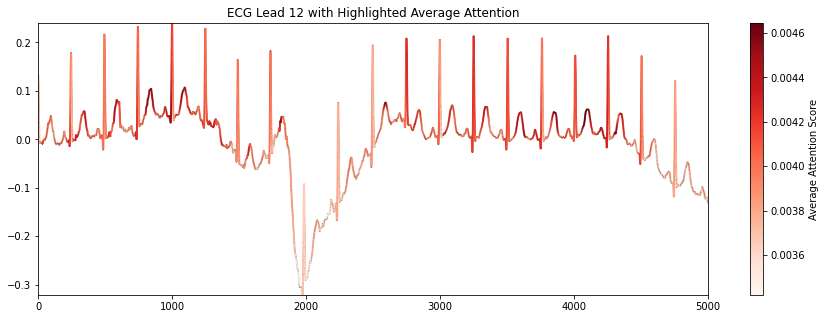

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

# 리드의 index를 선택합니다.
lead_index = 11  # 예시로 첫 번째 리드를 선택

# ECG 데이터와 모든 head의 attention 값 평균
ecg_data_lead = ecg_data[:, lead_index]  # 선택한 리드의 ECG 데이터
attn_avg = np.mean(attn, axis=1)  # 모든 head의 attention 값의 평균

# x 축 좌표 생성
x = np.linspace(0, len(ecg_data_lead), len(ecg_data_lead))

# 전체 ECG 데이터를 검정색 라인으로 플롯
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x, ecg_data_lead, color='black', linewidth=1, label=f'Lead {lead_index + 1}')

# 컬러맵과 노멀라이제이션 설정
cmap = plt.get_cmap('Reds')
# Normalize 범위를 설정하여 강조를 극대화합니다
norm = Normalize(vmin=np.min(attn_avg), vmax=np.max(attn_avg))

# 강조할 부분만을 별도로 계산
points = np.array([x, ecg_data_lead]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(attn_avg)  # 평균화된 attn 값에 따라 색상을 설정
lc.set_linewidth(2)

# 강조된 부분을 검정색 라인 위에 덮어쓰기
ax.add_collection(lc)

# 컬러바 추가
fig.colorbar(lc, ax=ax, label='Average Attention Score')

# 그래프 설정
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ecg_data_lead.min(), ecg_data_lead.max())
ax.set_title(f'ECG Lead {lead_index + 1} with Highlighted Average Attention')

plt.show()


- lead, attention head 별로

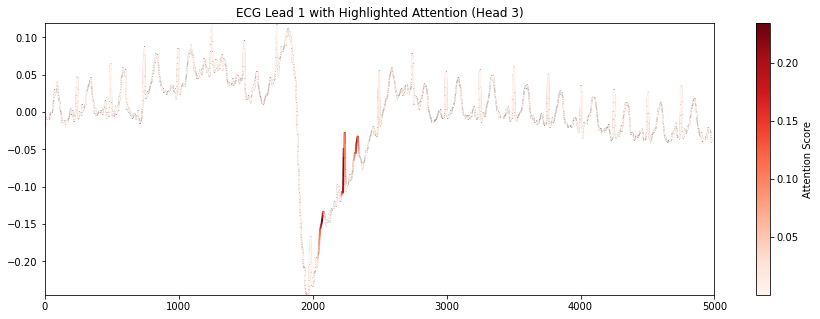

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

# 리드의 index와 attention head를 선택합니다.
lead_index = 0  # 예시로 첫 번째 리드를 선택
head_index = 2  # 예시로 첫 번째 head를 선택

# ECG 데이터와 attention 값
ecg_data_lead = ecg_data[:, lead_index]  # 선택한 리드의 ECG 데이터
attn_lead = attn[:, head_index]  # 선택한 head의 attention 값

# x 축 좌표 생성
x = np.linspace(0, len(ecg_data_lead), len(ecg_data_lead))

# 전체 ECG 데이터를 검정색 라인으로 플롯
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x, ecg_data_lead, color='black', linewidth=1, label=f'Lead {lead_index + 1}')

# 컬러맵과 노멀라이제이션 설정
cmap = plt.get_cmap('Reds')
# Normalize 범위를 설정하여 강조를 극대화합니다
norm = Normalize(vmin=np.min(attn_lead), vmax=np.max(attn_lead))

# 강조할 부분만을 별도로 계산
points = np.array([x, ecg_data_lead]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(attn_lead)  # attn_lead 값에 따라 색상을 설정
lc.set_linewidth(2)

# 강조된 부분을 검정색 라인 위에 덮어쓰기
ax.add_collection(lc)

# 컬러바 추가
fig.colorbar(lc, ax=ax, label='Attention Score')

# 그래프 설정
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ecg_data_lead.min(), ecg_data_lead.max())
ax.set_title(f'ECG Lead {lead_index + 1} with Highlighted Attention (Head {head_index + 1})')

plt.show()


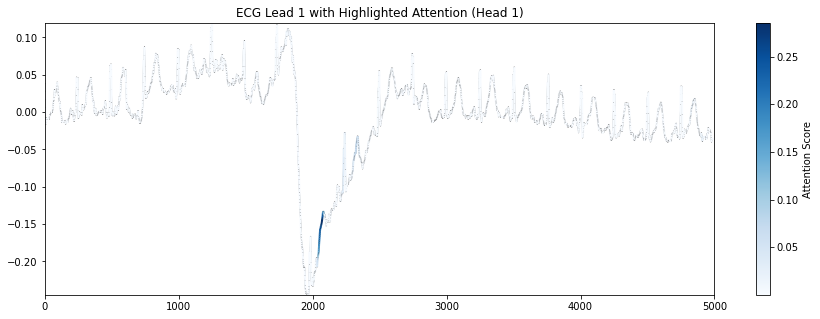

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

# 리드의 index와 attention head를 선택합니다.
lead_index = 0  # 예시로 첫 번째 리드를 선택
head_index = 0  # 예시로 첫 번째 head를 선택

# ECG 데이터와 attention 값
ecg_data_lead = ecg_data[:, lead_index]  # 선택한 리드의 ECG 데이터
attn_lead = attn[:, head_index]  # 선택한 head의 attention 값

# x 축 좌표 생성
x = np.linspace(0, len(ecg_data_lead), len(ecg_data_lead))

# 전체 ECG 데이터를 검정색 라인으로 플롯
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x, ecg_data_lead, color='black', linewidth=1, label=f'Lead {lead_index + 1}')

# 컬러맵과 노멀라이제이션 설정
cmap = plt.get_cmap('Blues')
norm = Normalize(vmin=np.min(attn_lead), vmax=np.max(attn_lead))

# LineCollection을 사용하여 선에 따라 색상을 다르게 설정
points = np.array([x, ecg_data_lead]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(attn_lead)  # attn_lead 값에 따라 색상을 설정
lc.set_linewidth(2)
lc.set_alpha(1.0)
# 강조된 부분을 검정색 라인 위에 덮어쓰기
ax.add_collection(lc)

# 컬러바 추가
fig.colorbar(lc, ax=ax, label='Attention Score')

# 그래프 설정
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ecg_data_lead.min(), ecg_data_lead.max())
ax.set_title(f'ECG Lead {lead_index + 1} with Highlighted Attention (Head {head_index + 1})')

plt.show()


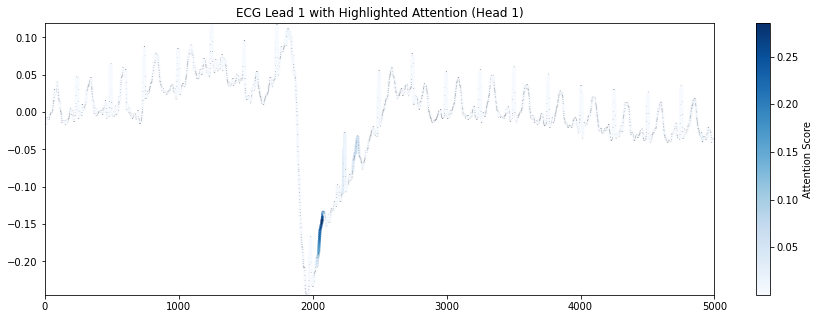

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

# 리드의 index와 attention head를 선택합니다.
lead_index = 0  # 예시로 첫 번째 리드를 선택
head_index = 0  # 예시로 첫 번째 head를 선택

# ECG 데이터와 attention 값
ecg_data_lead = ecg_data[:, lead_index]  # 선택한 리드의 ECG 데이터
attn_lead = attn[:, head_index]  # 선택한 head의 attention 값

# x 축 좌표 생성
x = np.linspace(0, len(ecg_data_lead), len(ecg_data_lead))

# 컬러맵과 노멀라이제이션 설정
cmap = plt.get_cmap('Blues')
norm = Normalize(vmin=np.min(attn_lead), vmax=np.max(attn_lead))

# LineCollection을 사용하여 선에 따라 색상을 다르게 설정
points = np.array([x, ecg_data_lead]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(attn_lead)  # attn_lead 값에 따라 색상을 설정
lc.set_linewidth(3)

# 전체 ECG 라인 플롯
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x, ecg_data_lead, color='black', linewidth=1, label=f'Lead {lead_index + 1}')

# 강조된 부분을 표시
ax.add_collection(lc)

# 컬러바 추가
fig.colorbar(lc, ax=ax, label='Attention Score')

# 그래프 설정
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ecg_data_lead.min(), ecg_data_lead.max())
ax.set_title(f'ECG Lead {lead_index + 1} with Highlighted Attention (Head {head_index + 1})')

plt.show()



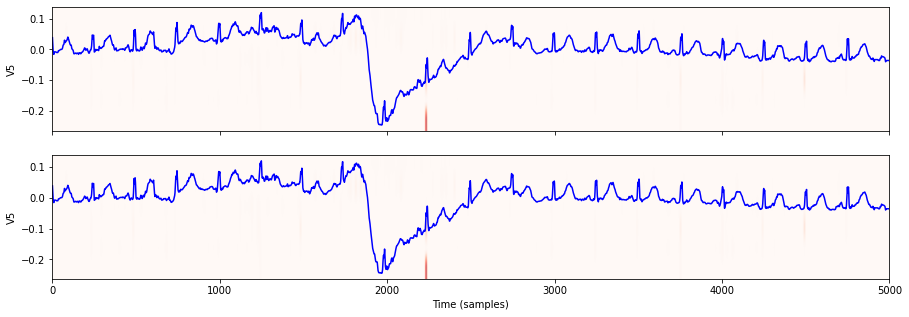

In [62]:
import matplotlib.pyplot as plt

# 예시로 두 개의 리드에 대해 attention 맵을 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

# 시각화할 리드 인덱스
lead_index = 0  # V5 리드

# 두 번째 리드도 같은 index를 사용 (두 리드 모두 동일한 리드인 경우)
for i in range(2):
    ax = axes[i]
    ax.plot(ecg_data[:, lead_index], label='V5', color='blue')
    ax.imshow(attn[:, :].numpy().T, aspect='auto', cmap='Reds', alpha=0.6, extent=[0, 5000, ax.get_ylim()[0], ax.get_ylim()[1]])
    ax.set_ylabel('V5')
    ax.set_xlim([0, 5000])

plt.xlabel('Time (samples)')
plt.show()


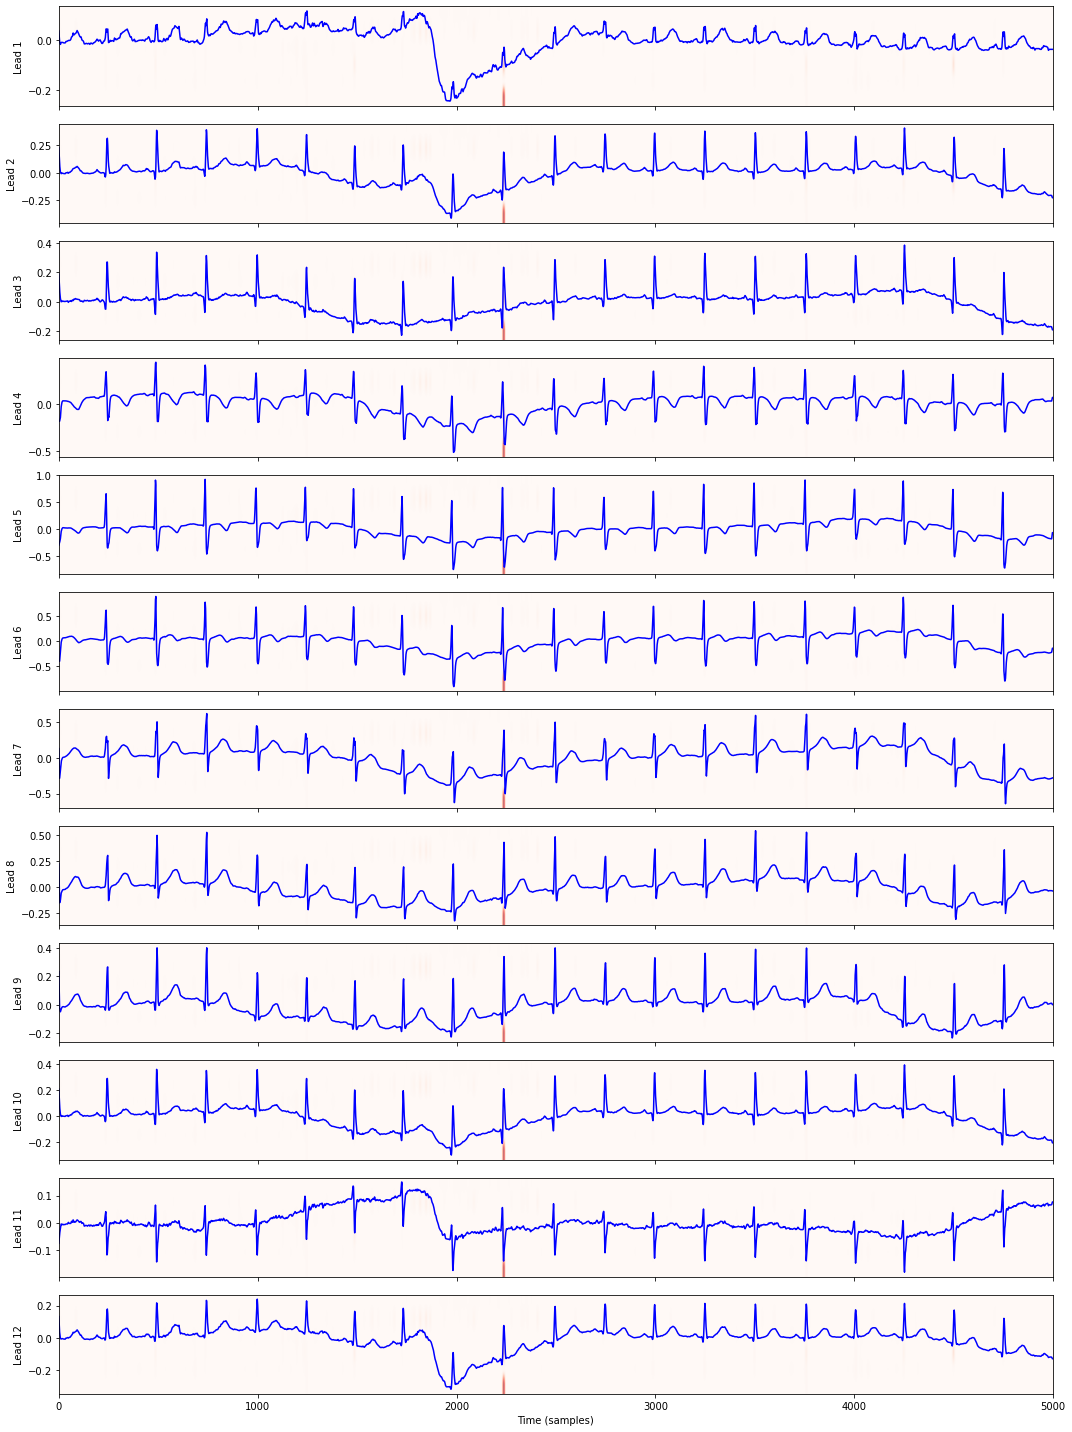

In [63]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# 이전에 정의한 ECG 데이터를 불러오고, 모델을 통해 self-attention 맵을 얻습니다.
# 예시 데이터 및 self-attention 맵을 가져오는 과정은 생략했습니다.

# 예시: 12개의 리드 (5000, 12)의 self-attention 맵 시각화
fig, axes = plt.subplots(12, 1, figsize=(15, 20), sharex=True)

# 12개의 리드 각각에 대해 시각화
for lead_index in range(12):
    ax = axes[lead_index]
    
    # 현재 리드에 대한 ECG 신호 시각화
    ax.plot(ecg_data[:, lead_index], label=f'Lead {lead_index + 1}', color='blue')
    
    # 현재 리드에 대한 Attention 맵 시각화
    ax.imshow(attn[:, :].numpy().T, aspect='auto', cmap='Reds', alpha=0.6, extent=[0, 5000, ax.get_ylim()[0], ax.get_ylim()[1]])
    
    # Y축 라벨 설정
    ax.set_ylabel(f'Lead {lead_index + 1}')
    ax.set_xlim([0, 5000])

# X축 라벨 설정
plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


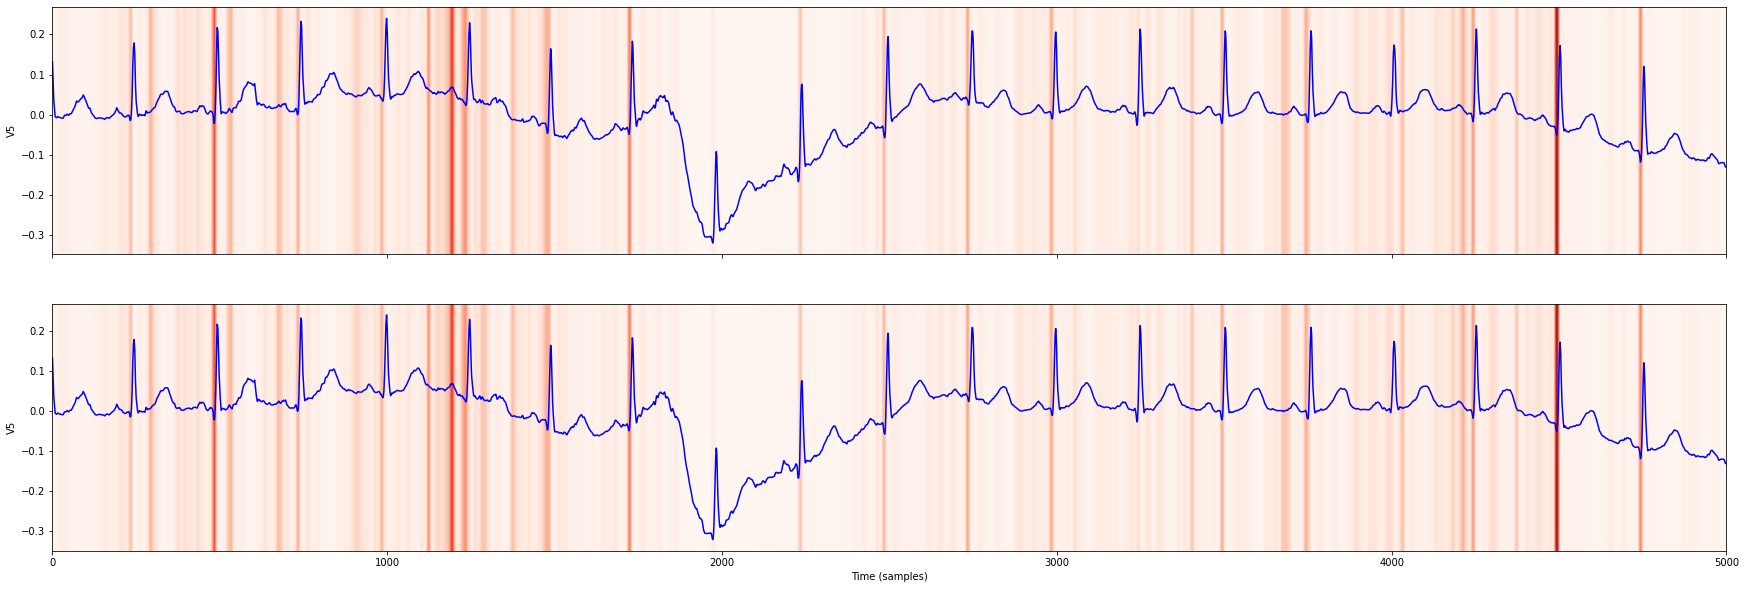

In [64]:
# 첫 번째 head만 시각화
attn_head_1 = attn[:, 2].numpy()

fig, axes = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

for i in range(2):
    ax = axes[i]
    ax.plot(ecg_data[:, lead_index], label='V5', color='blue')
    ax.imshow(attn_head_1[:, np.newaxis].T, aspect='auto', cmap='Reds', alpha=0.9, extent=[0, 5000, ax.get_ylim()[0], ax.get_ylim()[1]])
    ax.set_ylabel('V5')
    ax.set_xlim([0, 5000])

plt.xlabel('Time (samples)')
plt.show()


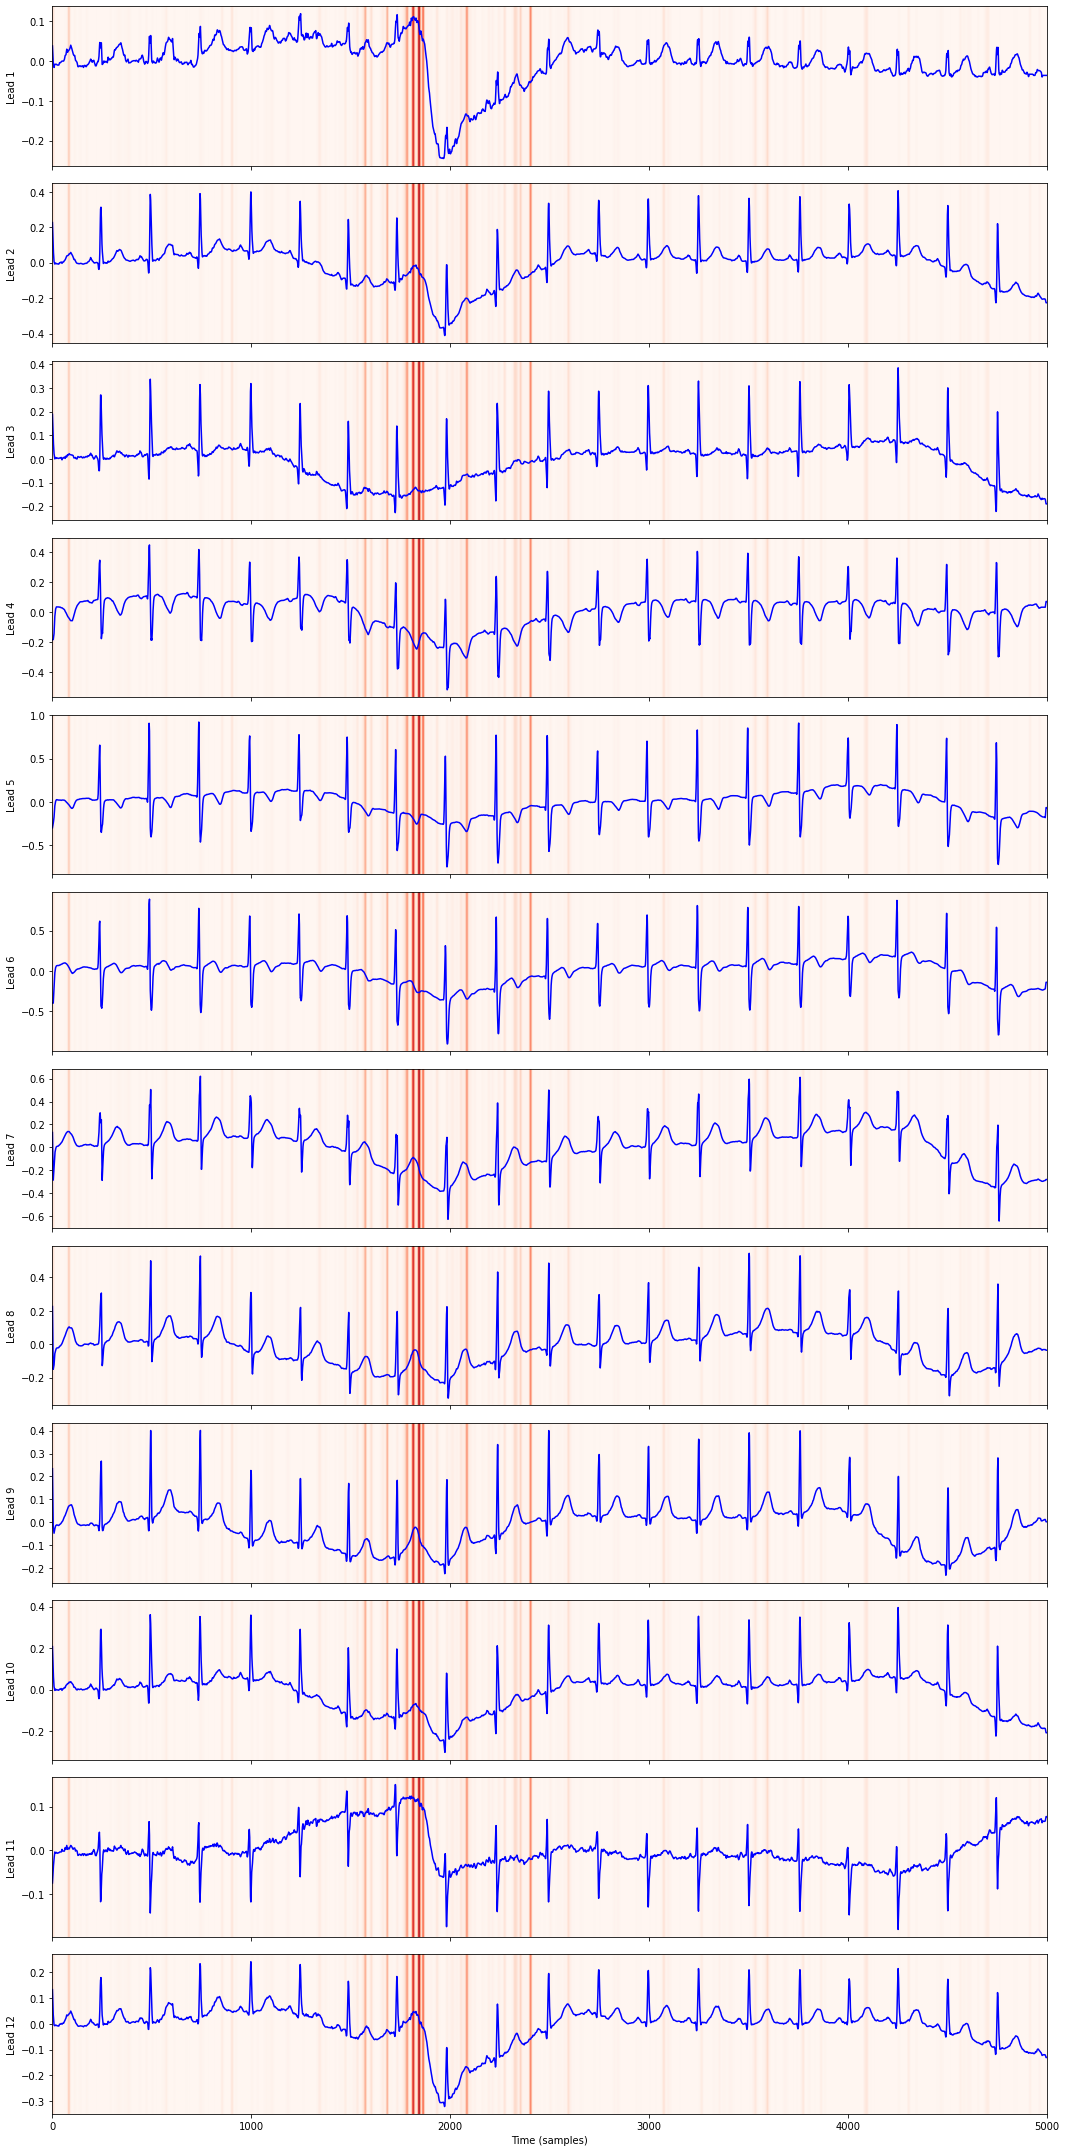

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# 첫 번째 head의 attention 스코어를 가져옵니다.
attn_head_1 = attn[:, 1].numpy()  # (5000,) 크기의 배열

# 12개의 리드에 대해 시각화
fig, axes = plt.subplots(12, 1, figsize=(15, 30), sharex=True)

for lead_index in range(12):
    ax = axes[lead_index]
    ax.plot(ecg_data[:, lead_index], label=f'Lead {lead_index + 1}', color='blue')
    ax.imshow(attn_head_1[:, np.newaxis].T, aspect='auto', cmap='Reds', alpha=0.9, extent=[0, 5000, ax.get_ylim()[0], ax.get_ylim()[1]])
    ax.set_ylabel(f'Lead {lead_index + 1}')
    ax.set_xlim([0, 5000])

# 공통 X축 라벨 설정
plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 'attn' 텐서의 모양을 출력하여 확인합니다.
print("Attention tensor shape:", attn.shape)

# 12개의 리드에 대해 각각의 attention 맵을 개별적으로 계산하고 시각화
fig, axes = plt.subplots(12, 1, figsize=(15, 30), sharex=True)

# 12개의 리드에 대해 시각화 진행
for lead_index in range(12):
    # head_index를 계산하여 각 리드에 해당하는 head를 선택
    head_index = lead_index % attn.shape[1]  # num_heads 만큼 반복

    # 리드별 attention 계산
    attn_head = attn[:, head_index]  # 모든 샘플, head 선택

    # 각 패치를 원래 시퀀스 길이로 확장 (이미 5000 길이로 되어 있을 것임)
    attn_resized = np.squeeze(attn_head)
    if attn_resized.ndim == 1:
        attn_resized = attn_resized[np.newaxis, :]  # 2D 형태로 변환 (1, width)

    ax = axes[lead_index]
    ax.plot(ecg_data[:, lead_index], label=f'Lead {lead_index + 1}', color='blue')
    ax.imshow(attn_resized, aspect='auto', cmap='Reds', alpha=0.9, extent=[0, 5000, ax.get_ylim()[0], ax.get_ylim()[1]])
    ax.set_ylabel(f'Lead {lead_index + 1}')
    ax.set_xlim([0, 5000])

    # subplot 제목에 head_index를 추가하여 몇 번째 head인지 표시
    ax.set_title(f'Head {head_index + 1} Attention for Lead {lead_index + 1}', fontsize=10)

# 공통 X축 라벨 설정
plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


2024-08-19 05:19:12.528566: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: Index out of range using input dim 2; input has only 2 dims


InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

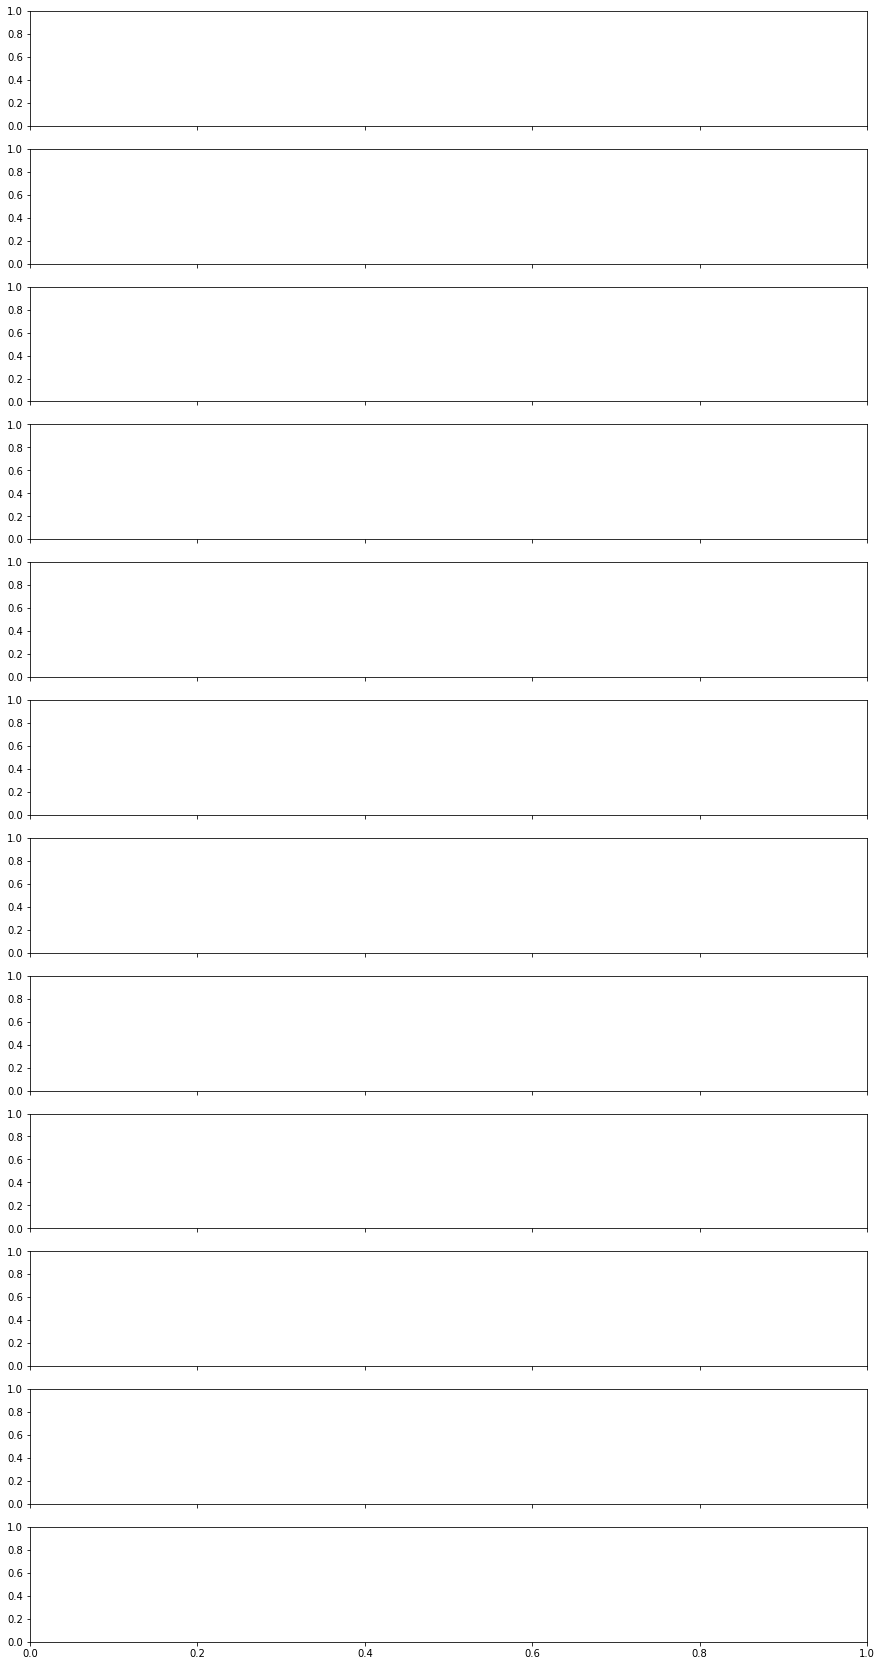

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# 12개의 리드에 대해 각각의 attention 맵을 개별적으로 계산하고 시각화
fig, axes = plt.subplots(12, 1, figsize=(15, 30), sharex=True)

# 12개의 리드에 대해 시각화 진행
for lead_index in range(12):
    # 리드별 attention 계산
    attn_head = attn[0, lead_index % attn.shape[1], 1:]  # 첫 번째 배치, head 선택, 첫 번째 패치를 제외한 attention map

    # 각 패치를 원래 시퀀스 길이로 확장
    attn_resized = np.repeat(attn_head, 5000 // attn_head.shape[-1], axis=-1)
    
    # 필요에 따라 2D로 변환
    attn_resized = np.squeeze(attn_resized)
    if attn_resized.ndim == 1:
        attn_resized = attn_resized[np.newaxis, :]  # 2D 형태로 변환 (1, width)

    ax = axes[lead_index]
    ax.plot(ecg_data[:, lead_index], label=f'Lead {lead_index + 1}', color='blue')
    ax.imshow(attn_resized, aspect='auto', cmap='Reds', alpha=0.9, extent=[0, 5000, ax.get_ylim()[0], ax.get_ylim()[1]])
    ax.set_ylabel(f'Lead {lead_index + 1}')
    ax.set_xlim([0, 5000])

# 공통 X축 라벨 설정
plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()



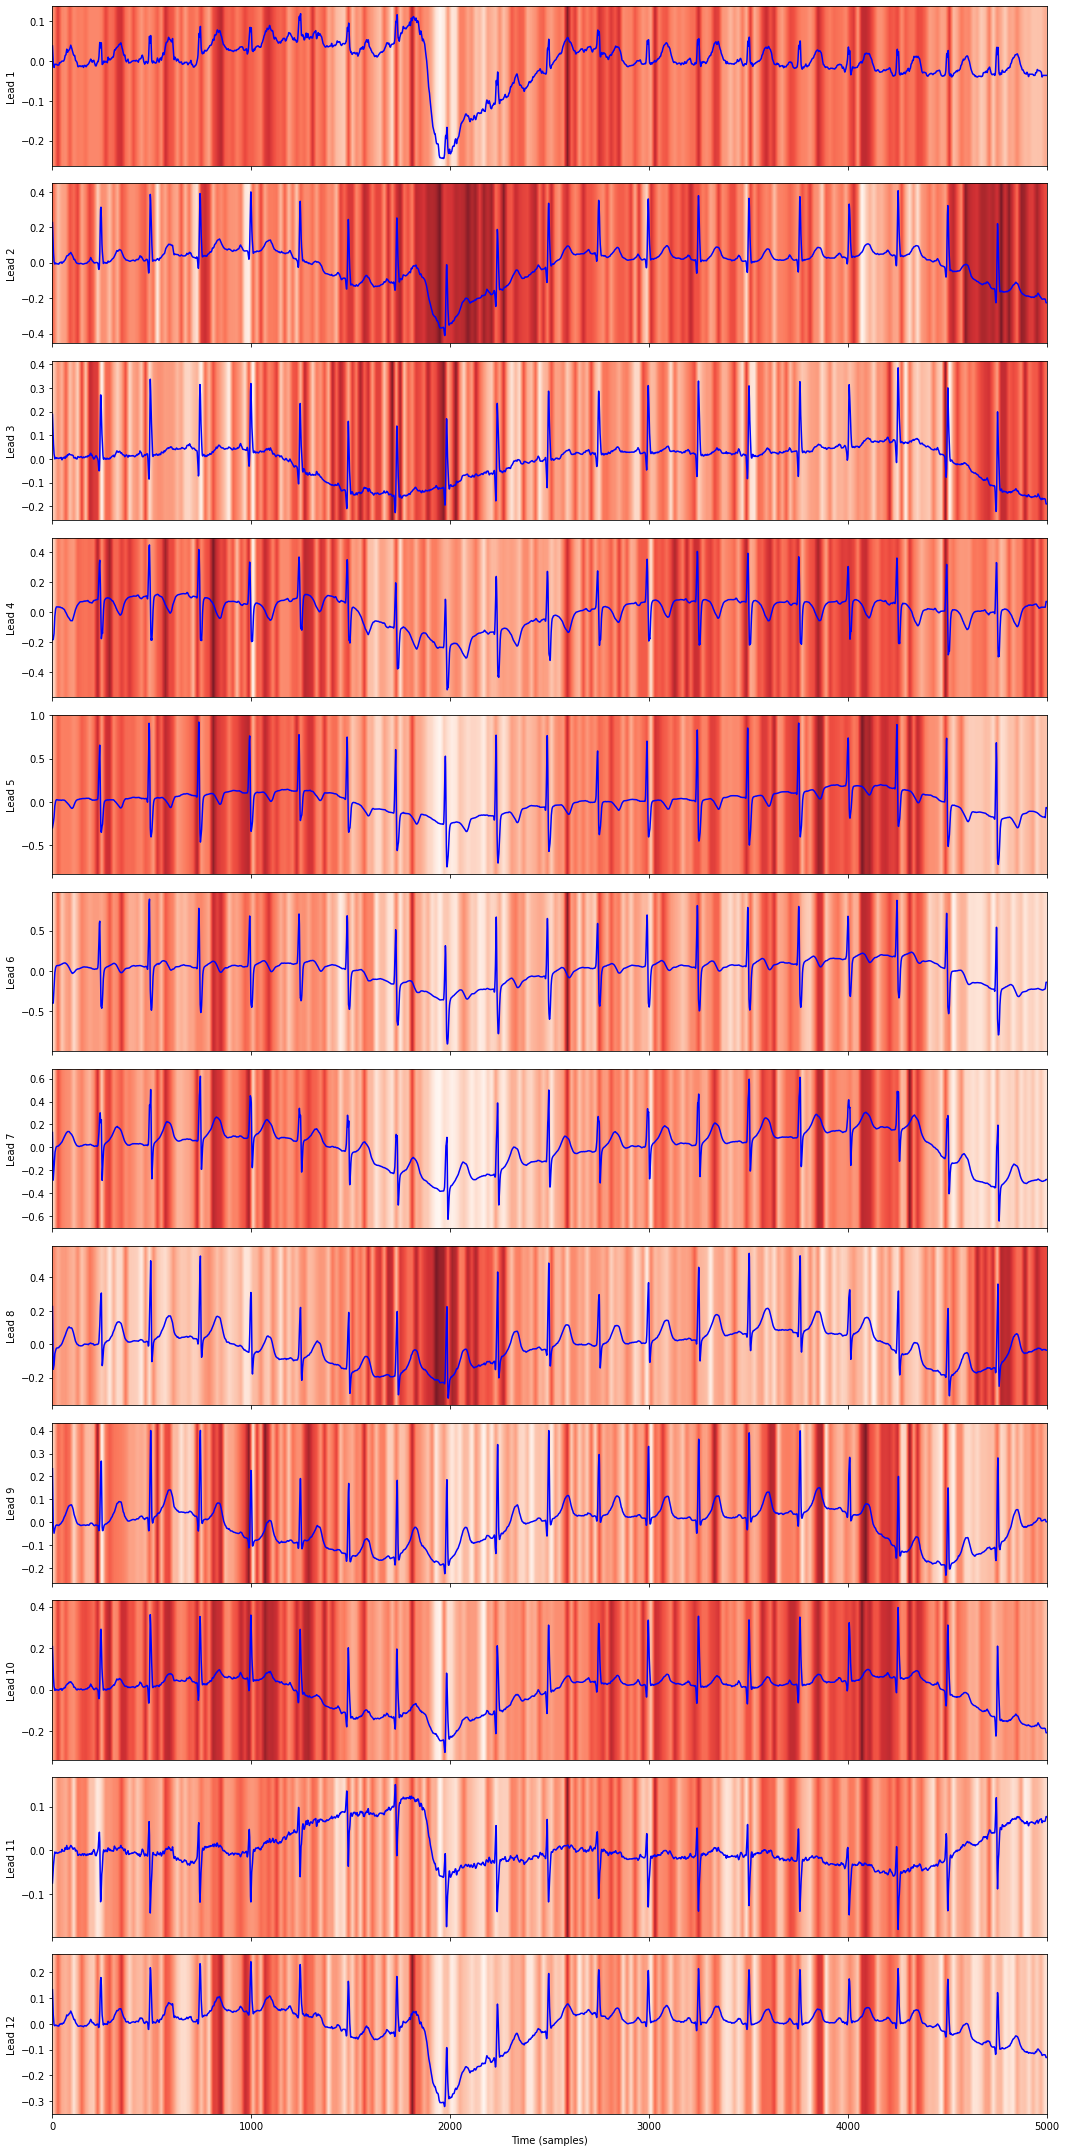

: 

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# 12개의 리드에 대해 각각의 attention 맵을 개별적으로 계산하고 시각화
fig, axes = plt.subplots(12, 1, figsize=(15, 30), sharex=True)

for lead_index in range(12):
    # 리드별 attention 계산 (예: 각 리드에 대해 개별 attention 맵을 계산할 경우)
    attn_head = attn[:, lead_index].numpy()  # 각 리드의 attention 맵
    
    ax = axes[lead_index]
    ax.plot(ecg_data[:, lead_index], label=f'Lead {lead_index + 1}', color='blue')
    ax.imshow(attn_head[:, np.newaxis].T, aspect='auto', cmap='Reds', alpha=0.9, extent=[0, 5000, ax.get_ylim()[0], ax.get_ylim()[1]])
    ax.set_ylabel(f'Lead {lead_index + 1}')
    ax.set_xlim([0, 5000])

# 공통 X축 라벨 설정
plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()




Attention map shape: (5000, 6)
Lead 1: Max Attention Position = 2095
Lead 2: Max Attention Position = 1844
Lead 3: Max Attention Position = 4494
Lead 4: Max Attention Position = 2234
Lead 5: Max Attention Position = 3754
Lead 6: Max Attention Position = 2234


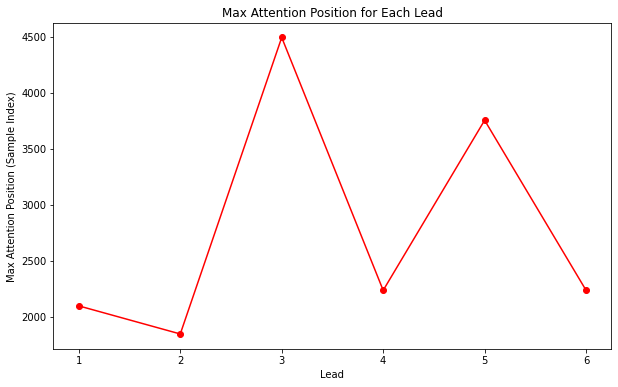

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Attention map의 모양을 확인합니다.
print("Attention map shape:", attn.shape)

# 최고 attention score 위치를 저장할 리스트
max_attention_positions = []

# 각 리드별로 최고 attention score 위치를 계산합니다.
for lead_index in range(min(attn.shape[1], 12)):  # 배열의 범위 내에서 인덱싱을 수행합니다.
    # 각 리드에서 최고 attention score의 위치를 찾습니다.
    max_pos = np.argmax(attn[:, lead_index])
    max_attention_positions.append(max_pos)

# 최고 attention score 위치를 출력합니다.
for lead_index, pos in enumerate(max_attention_positions):
    print(f"Lead {lead_index + 1}: Max Attention Position = {pos}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(max_attention_positions) + 1), max_attention_positions, 'o-', color='red')
plt.xlabel('Lead')
plt.ylabel('Max Attention Position (Sample Index)')
plt.title('Max Attention Position for Each Lead')
plt.xticks(range(1, len(max_attention_positions) + 1))
plt.show()


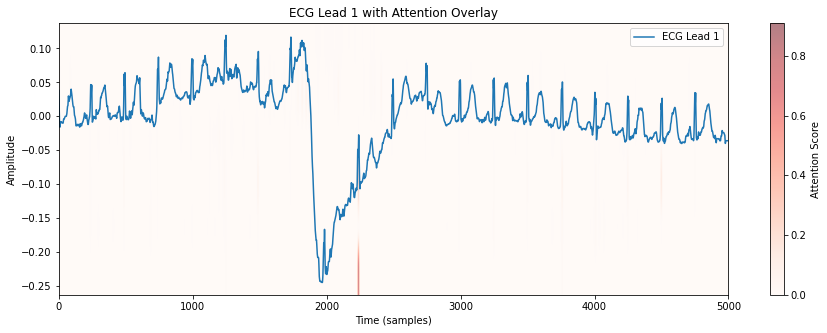

In [67]:
# ECG 리드와 attention 스코어 시각화
lead_index = 0  # 12개 리드 중 하나를 선택 (예: 'I' 리드)
plt.figure(figsize=(15, 5))

plt.plot(ecg_data[:, lead_index], label='ECG Lead {}'.format(lead_index + 1))
plt.imshow(attn[:, :].numpy().T, aspect='auto', cmap='Reds', alpha=0.5, extent=[0, 5000, plt.ylim()[0], plt.ylim()[1]])

plt.colorbar(label="Attention Score")
plt.title('ECG Lead {} with Attention Overlay'.format(lead_index + 1))
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


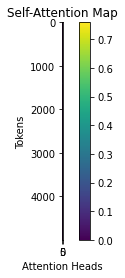

In [81]:
import matplotlib.pyplot as plt

# 첫 번째 attention head의 맵을 시각화
plt.imshow(attn[ :, :].numpy(), cmap='viridis')
plt.colorbar()
plt.title('Self-Attention Map')
plt.xlabel('Attention Heads')
plt.ylabel('Tokens')
plt.show()



Attention Map Shape: (5000, 6)
Head 1: Mean Attention Score = 0.0019991484005004168
Head 2: Mean Attention Score = 0.0019997290801256895
Head 3: Mean Attention Score = 0.0019897473976016045
Head 4: Mean Attention Score = 0.0019950007554143667
Head 5: Mean Attention Score = 0.001997827086597681
Head 6: Mean Attention Score = 0.002000498818233609
Most Influential Head: Head 6


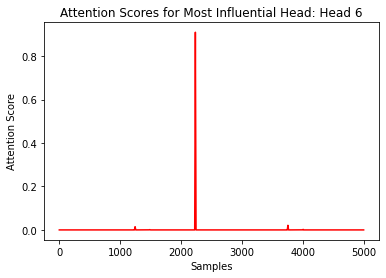

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Attention Map의 모양 확인
print("Attention Map Shape:", attn.shape)

# 각 head의 평균 attention 스코어 계산
mean_attn_scores = tf.reduce_mean(attn, axis=0).numpy()  # (6,)

# 각 head의 attention 스코어 출력
for i, score in enumerate(mean_attn_scores):
    print(f"Head {i + 1}: Mean Attention Score = {score}")

# 가장 큰 영향을 주는 head 식별
most_influential_head = np.argmax(mean_attn_scores)
print(f"Most Influential Head: Head {most_influential_head + 1}")

# 가장 큰 영향을 주는 head 시각화
attn_head = attn[:, most_influential_head].numpy()  # (5000,)

# 시각화
plt.plot(attn_head, color='red')
plt.title(f'Attention Scores for Most Influential Head: Head {most_influential_head + 1}')
plt.xlabel('Samples')
plt.ylabel('Attention Score')
plt.show()
